In [1]:
import os
import pandas as pd
from pathlib import Path
curr_dir = Path(os.getcwd())
data_dir = curr_dir.parent / "Phase_1" / "train_FD001_phase_1.csv"
df = pd.read_csv(data_dir)

df.head()   

,Unnamed: 0,Engine no,Num cycles,Operating 1,Operating 2,Operating 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Stage
0,0,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,0
1,1,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,0
2,2,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,0
3,3,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,0
4,4,1,6,-0.0043,-0.0001,100.0,518.67,642.10,1584.47,1398.37,...,2388.03,8132.85,8.4108,0.03,391,2388,100.0,38.98,23.3669,0


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Features: all sensors
sensor_cols = [col for col in df.columns if col.startswith('Sensor')]
X = df[sensor_cols]
y = df['Stage']

# Normalize
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)


In [3]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


In [4]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, digits=4))


              precision    recall  f1-score   support

           0     0.8965    0.9032    0.8998       940
           1     0.8015    0.7970    0.7993      1079
           2     0.8092    0.8495    0.8288      1103
           3     0.8547    0.7678    0.8089       590
           4     0.8995    0.9082    0.9038       414

    accuracy                         0.8422      4126
   macro avg     0.8523    0.8451    0.8481      4126
weighted avg     0.8426    0.8422    0.8420      4126



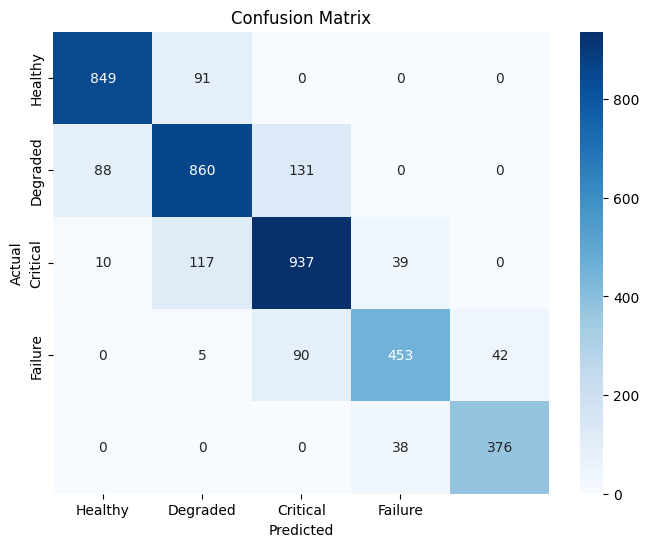

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Healthy', 'Degraded', 'Critical', 'Failure'],
            yticklabels=['Healthy', 'Degraded', 'Critical', 'Failure'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [6]:
df_rolling = df.copy()

# Ensure engine_id and cycle are sorted for rolling operations
df_rolling.sort_values(by=['Engine no', 'Num cycles'], inplace=True)

window = 5
sensor_cols = [col for col in df.columns if col.startswith('Sensor')]

for col in sensor_cols:
    df_rolling[f'{col}_mean5'] = df_rolling.groupby('Engine no')[col].transform(lambda x: x.rolling(window, min_periods=1).mean())
    df_rolling[f'{col}_std5'] = df_rolling.groupby('Engine no')[col].transform(lambda x: x.rolling(window, min_periods=1).std().fillna(0))


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Features = all sensor cols + rolling stats
feature_cols = [col for col in df_rolling.columns if col.startswith('Sensor')]
X = df_rolling[feature_cols]
y = df_rolling['Stage']

# Normalize
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)


In [8]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

xgb = XGBClassifier(objective='multi:softmax',
                    num_class=4,
                    eval_metric='mlogloss',
                    use_label_encoder=False,
                    scale_pos_weight=1,
                    random_state=42)

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred, digits=4))


c:\Users\deeti\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:55:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0     0.9563    0.9553    0.9558       940
           1     0.9088    0.9045    0.9066      1079
           2     0.9070    0.9284    0.9176      1103
           3     0.9265    0.8763    0.9007       590
           4     0.9272    0.9541    0.9405       414

    accuracy                         0.9234      4126
   macro avg     0.9252    0.9237    0.9242      4126
weighted avg     0.9235    0.9234    0.9233      4126



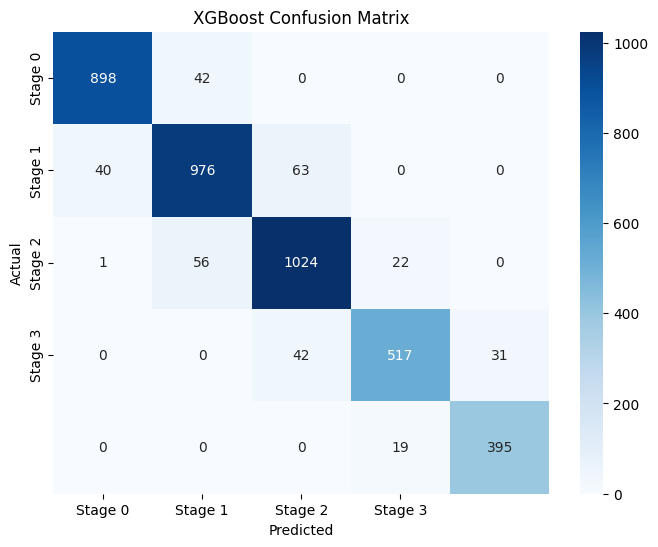

In [9]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Stage 0', 'Stage 1', 'Stage 2', 'Stage 3'],
            yticklabels=['Stage 0', 'Stage 1', 'Stage 2', 'Stage 3'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost Confusion Matrix")
plt.show()


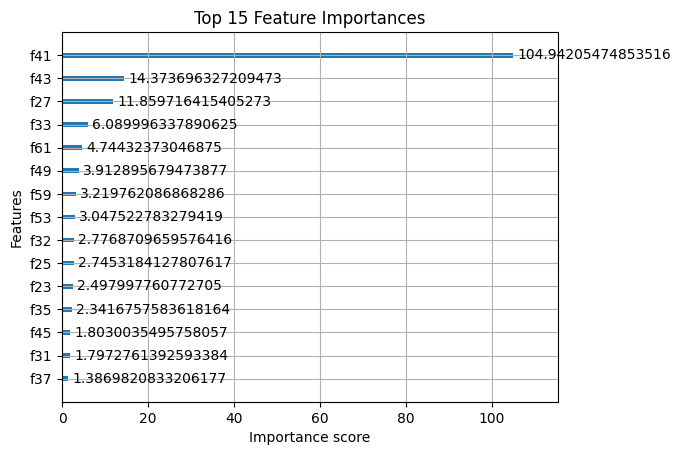

In [10]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(xgb, max_num_features=15, importance_type='gain')
plt.title("Top 15 Feature Importances")
plt.show()


In [11]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)


In [12]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred, average='macro')
print(f"Macro F1-score: {f1:.4f}")


Macro F1-score: 0.9242
